### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [35]:
bmi_ensemble = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/initialized_pop_with_updated_bmi_xmin_xmax.csv')

,tracked,exit_time,location,sex,age,alive,entrance_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_medication,lifestyle,outreach,sbp_medication,ldlc_multiplier,polypill,scheduled_date,visit_type,last_fpg_test_date,high_body_mass_index_in_adults.exposure
0,True,NaN,Alabama,Female,47.388882,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,one_drug_half_dose_efficacy,1.0,cat2,NaN,none,NaN,52.154698
1,True,NaN,Alabama,Male,41.564194,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,22.448880
2,True,NaN,Alabama,Female,53.155826,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,29.688637
3,True,NaN,Alabama,Male,30.457692,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,30.267318
4,True,NaN,Alabama,Female,19.554806,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,5.000000


In [38]:
bmi_ensemble = bmi_ensemble.loc[(bmi_ensemble.alive == 'alive') & (bmi_ensemble.age > 25)]
category = pd.cut(bmi_ensemble.age,bins=[25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,125],labels=['25_to_29','30_to_34','35_to_39','40_to_44','45_to_49','50_to_54','55_to_59','60_to_64','65_to_69','70_to_74','75_to_79','80_to_84','85_to_89','90_to_94','95_plus'])
bmi_ensemble['age_group'] = category
bmi_ensemble.loc[bmi_ensemble.age_group=='25_to_29']

,tracked,exit_time,location,sex,age,alive,entrance_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_medication,lifestyle,outreach,sbp_medication,ldlc_multiplier,polypill,scheduled_date,visit_type,last_fpg_test_date,high_body_mass_index_in_adults.exposure
6,True,NaN,Alabama,Male,28.652525,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,17.380871
23,True,NaN,Alabama,Male,28.103786,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,22.340968
25,True,NaN,Alabama,Male,26.000993,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,35.503791
30,True,NaN,Alabama,Female,27.750223,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,24.037929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49960,True,NaN,Alabama,Female,27.480569,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,16.097378
49968,True,NaN,Alabama,Male,26.668066,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,24.761645
49985,True,NaN,Alabama,Female,26.596939,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,25.861159
49996,True,NaN,Alabama,Male,26.389257,alive,2020-12-04,not_dead,0.0,NaN,...,no_treatment,NaN,cat2,no_treatment,1.0,cat2,NaN,none,NaN,32.572953


In [46]:
bmi_ensemble_group = (bmi_ensemble
                .groupby(['age_group', 'sex'])
                ['high_body_mass_index_in_adults.exposure'].describe(percentiles=[.025, 0.5, .975])
                .filter(['mean','50%', '2.5%', '97.5%'])
                .reset_index())
bmi_ensemble_group.head()

,age_group,sex,mean,50%,2.5%,97.5%
0,25_to_29,Female,28.438608,28.237558,5.000000,53.077999
1,25_to_29,Male,28.019941,27.241297,16.313035,43.438226
2,30_to_34,Female,28.984809,28.902788,5.000000,51.560774
3,30_to_34,Male,29.063827,28.341561,17.482370,44.999564
4,35_to_39,Female,29.564307,29.421305,5.000000,51.455572


In [56]:
bmi_ensemble.columns

Index(['tracked', 'exit_time', 'location', 'sex', 'age', 'alive',
       'entrance_time', 'cause_of_death', 'years_of_life_lost',
       'previous_ischemic_stroke',
       'previous_ischemic_heart_disease_and_heart_failure', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity', 'age_group',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity',
       'susceptible_to_ischemic_stroke_event_count',

## Comparison to Artifacts

In [7]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

51-locations/  alabama_before_calculated_pafs.hdf  washington.hdf
alabama.hdf    raw_data/


In [8]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [9]:
art_pop = art.load('population.structure').reset_index()
#art_pop.head()

In [10]:
#art.keys

In [64]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [65]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
#bmi_art.reset_index(inplace=True)
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,30.899912,30.892990,30.572156,31.233780,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,31.636913,31.638236,31.293987,31.989474,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,31.883495,31.884883,31.555235,32.210906,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,32.130649,32.123262,31.801051,32.462829,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,32.169931,32.165649,31.855765,32.505542,Alabama,exposure,45_to_49


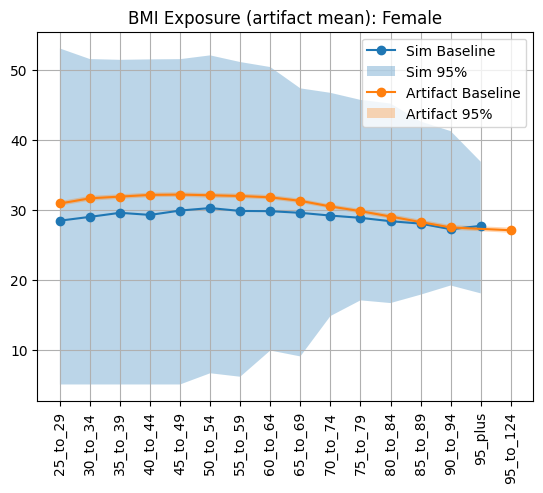

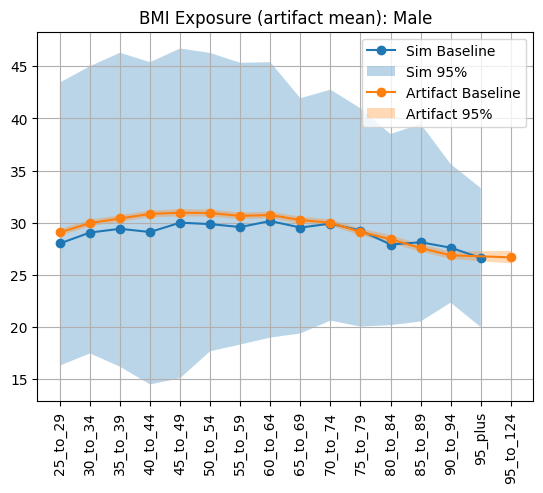

In [66]:
for sex in bmi_ensemble_group.sex.unique():
    plt.figure() 
    subdata = bmi_ensemble_group.loc[(bmi_ensemble_group.sex==sex)]
    plt.plot(subdata['age_group'], subdata['mean'], marker='o',label='Sim Baseline')
    plt.fill_between(subdata['age_group'], subdata['2.5%'], subdata['97.5%'], alpha=.3, label='Sim 95%')
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o', label='Artifact Baseline')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3, label='Artifact 95%')
    plt.title(f'BMI Exposure (artifact mean): {sex}') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend() 

In [57]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[['draw_0']]

        # collapse to desired percentiles
        #data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [59]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art.reset_index(inplace=True)
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,draw_0,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,30.727458,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,31.641113,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,31.890312,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,32.190598,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,32.154406,Alabama,exposure,45_to_49


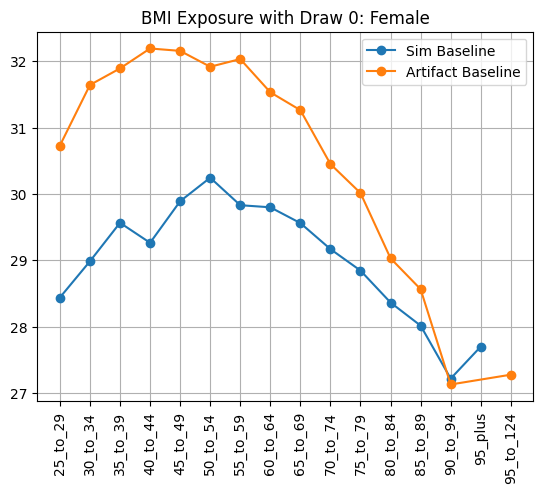

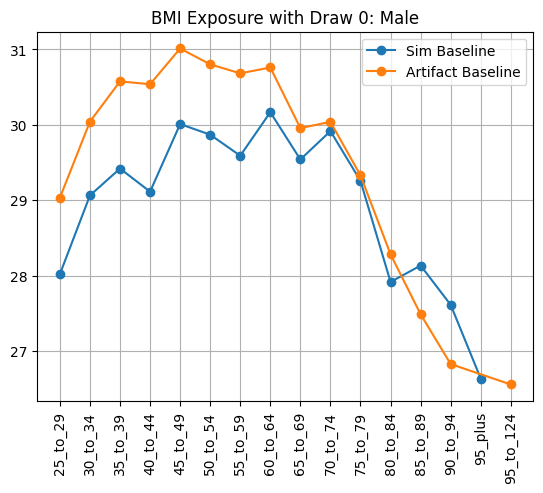

In [63]:
for sex in bmi_ensemble_group.sex.unique():
    plt.figure() 
    subdata = bmi_ensemble_group.loc[(bmi_ensemble_group.sex==sex)]
    plt.plot(subdata['age_group'], subdata['mean'], marker='o',label='Sim Baseline')
    #plt.fill_between(subdata['age_group'], subdata['2.5%'], subdata['97.5%'], alpha=.3, label='Sim 95%')
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['draw_0'], marker='o', label='Artifact Baseline')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3, label='Artifact 95%')
    plt.title(f'BMI Exposure with Draw 0: {sex}') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend() 